## Introduction to the automated analysis of EEG quality

This notebook will introduce you to the challenge by going through the data and working towards a first very simple model.

## Loading the data

In [66]:
## First let's load the training data
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import pandas as pd

ROOT_PATH = Path("train/")
training_data = [(np.load(ROOT_PATH / f"data_{i}.npy"),np.load(ROOT_PATH / f"target_{i}.npy")) for i in range(4)]


We expect to have five channels and one label per channel for each two seconds of data.
Let's have a look at the data duration and shape

In [67]:
# Let's have a look at the data duration
for i,(data,target) in enumerate(training_data):
    print()
    print(f"Recording {i}")
    print("Data shape", data.shape,target.shape)
    print("Data duration:", data.shape[1]/250)
    print("Labels duration",target.shape[1] * 2)
    



Recording 0
Data shape (5, 7712740) (5, 15425)
Data duration: 30850.96
Labels duration 30850

Recording 1
Data shape (5, 5232364) (5, 10464)
Data duration: 20929.456
Labels duration 20928

Recording 2
Data shape (5, 6421756) (5, 12843)
Data duration: 25687.024
Labels duration 25686

Recording 3
Data shape (5, 6809761) (5, 13619)
Data duration: 27239.044
Labels duration 27238


## Plotting the EEG and labels

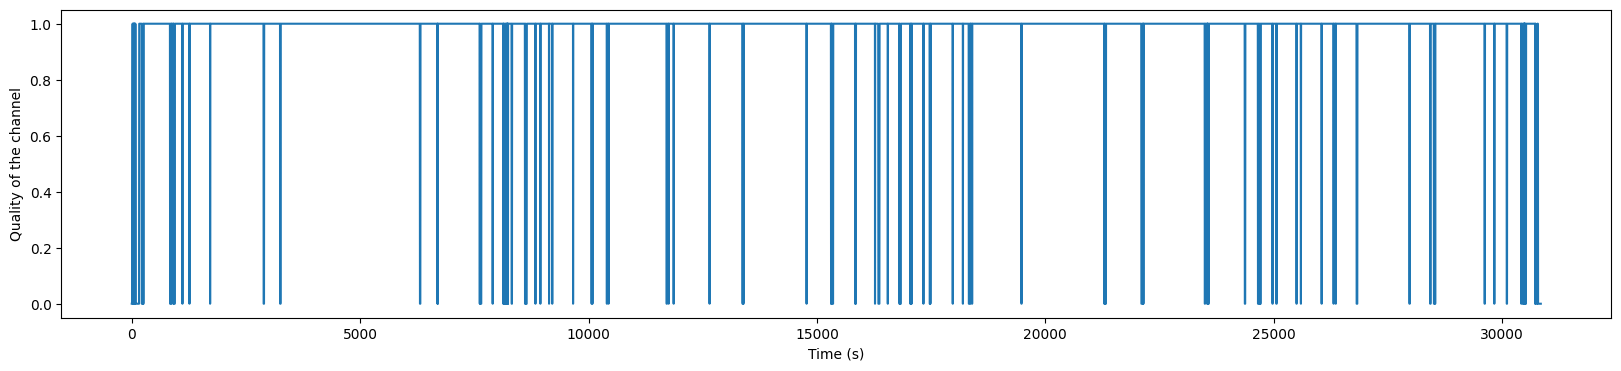

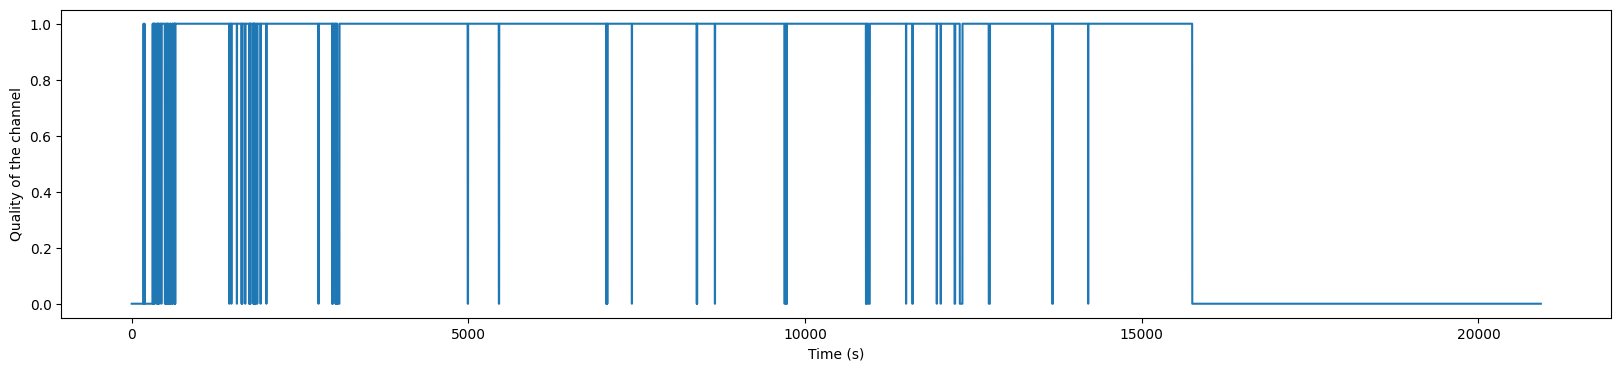

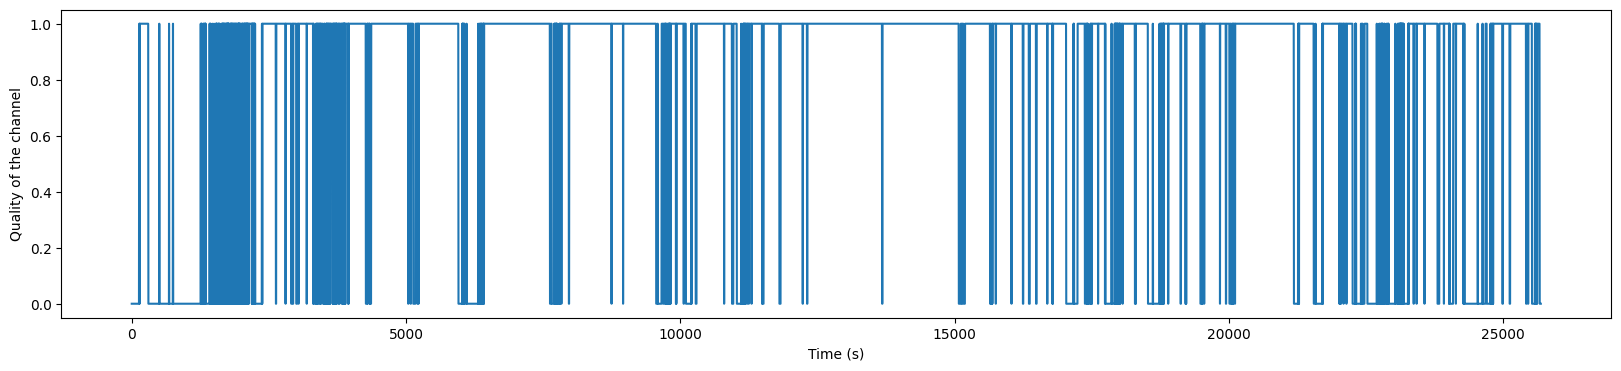

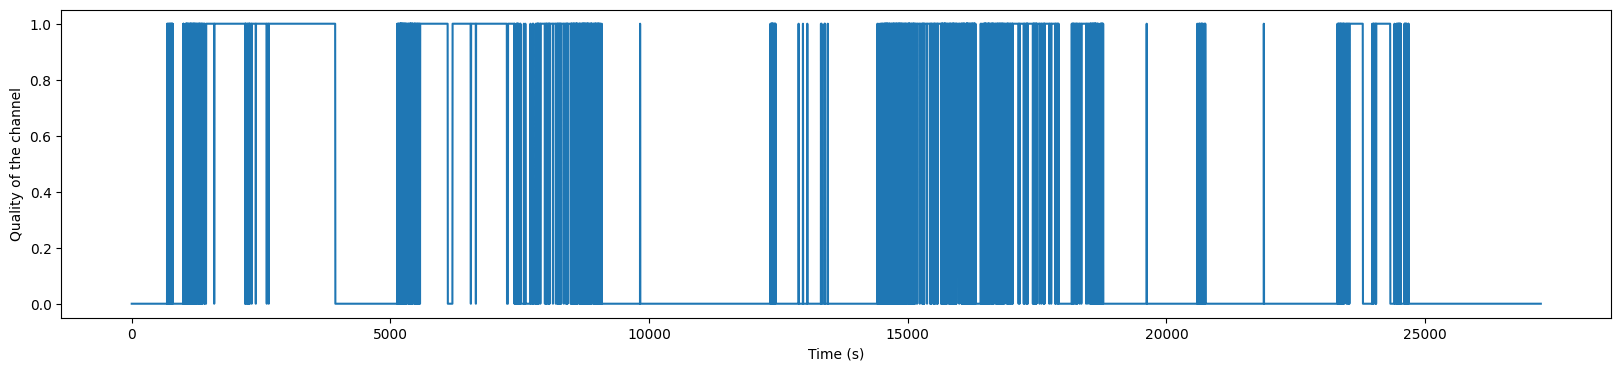

In [68]:

# Let's plot the target from the first channel for all the recordings
for i,(data,target) in enumerate(training_data):
    plt.figure(figsize=(20,4))
    plt.plot(np.arange(0,len(target[0])) * 2, target[0])
    plt.ylabel('Quality of the channel')
    plt.xlabel("Time (s)")
    plt.show()

In [69]:
## We improve a bit the plotting code to plot span of data and corresponding label

def plot_predictions_and_signal(
    target,
    data,
    start_time: float,
    stop_time: float,
    data_sampling_rate: int = 250,
    target_duration: int = 2,
    channel_to_plot: int = 0,
):
    """
    
    
    """

    # Calculate the start and stop indices for the signal
    start_idx_signal = int(start_time * data_sampling_rate)
    stop_idx_signal = int(stop_time * data_sampling_rate)

    # Calculate the start and stop indices for the labels
    start_idx_label = int(start_time / target_duration)
    stop_idx_label = int(stop_time / target_duration)

    # Slice the data and prediction probabilities
    sliced_signal = data[channel_to_plot, start_idx_signal:stop_idx_signal]
    sliced_prediction_prob = (
        target[channel_to_plot, start_idx_label:stop_idx_label]
    )

    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    # Plot the sliced EEG signal
    ax[0].plot(np.arange(len(sliced_signal)) / data_sampling_rate, sliced_signal)
    ax[0].set_title("EEG signal")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Amplitude")

    ax[1].plot(
        np.arange(len(sliced_prediction_prob)) * target_duration,
        sliced_prediction_prob,
    )
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Probs")

    plt.show()



0.5086964831804281


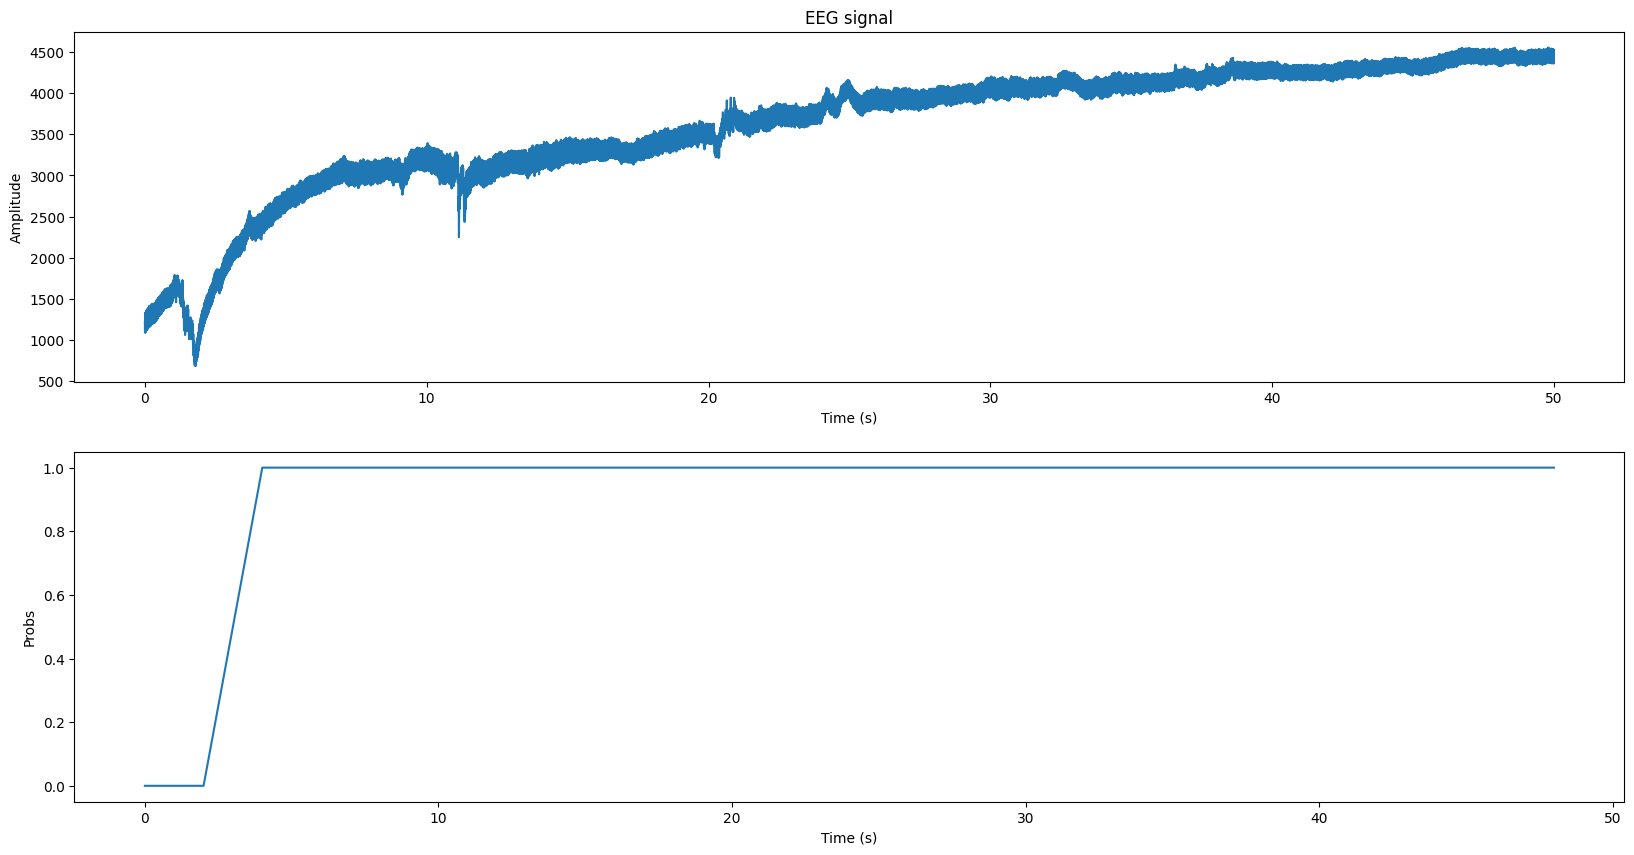

In [70]:
# We first plot the data and target from the first recording
# We see that there is a big DC component 
target = np.load("train/target_1.npy")
data = np.load("train/data_1.npy")
print(np.mean(target))
plot_predictions_and_signal(target,data,start_time = 300, stop_time = 350, data_sampling_rate = 250,target_duration = 2, channel_to_plot = 2)

To remove the DC component and high frequency component we apply a band-pass filter

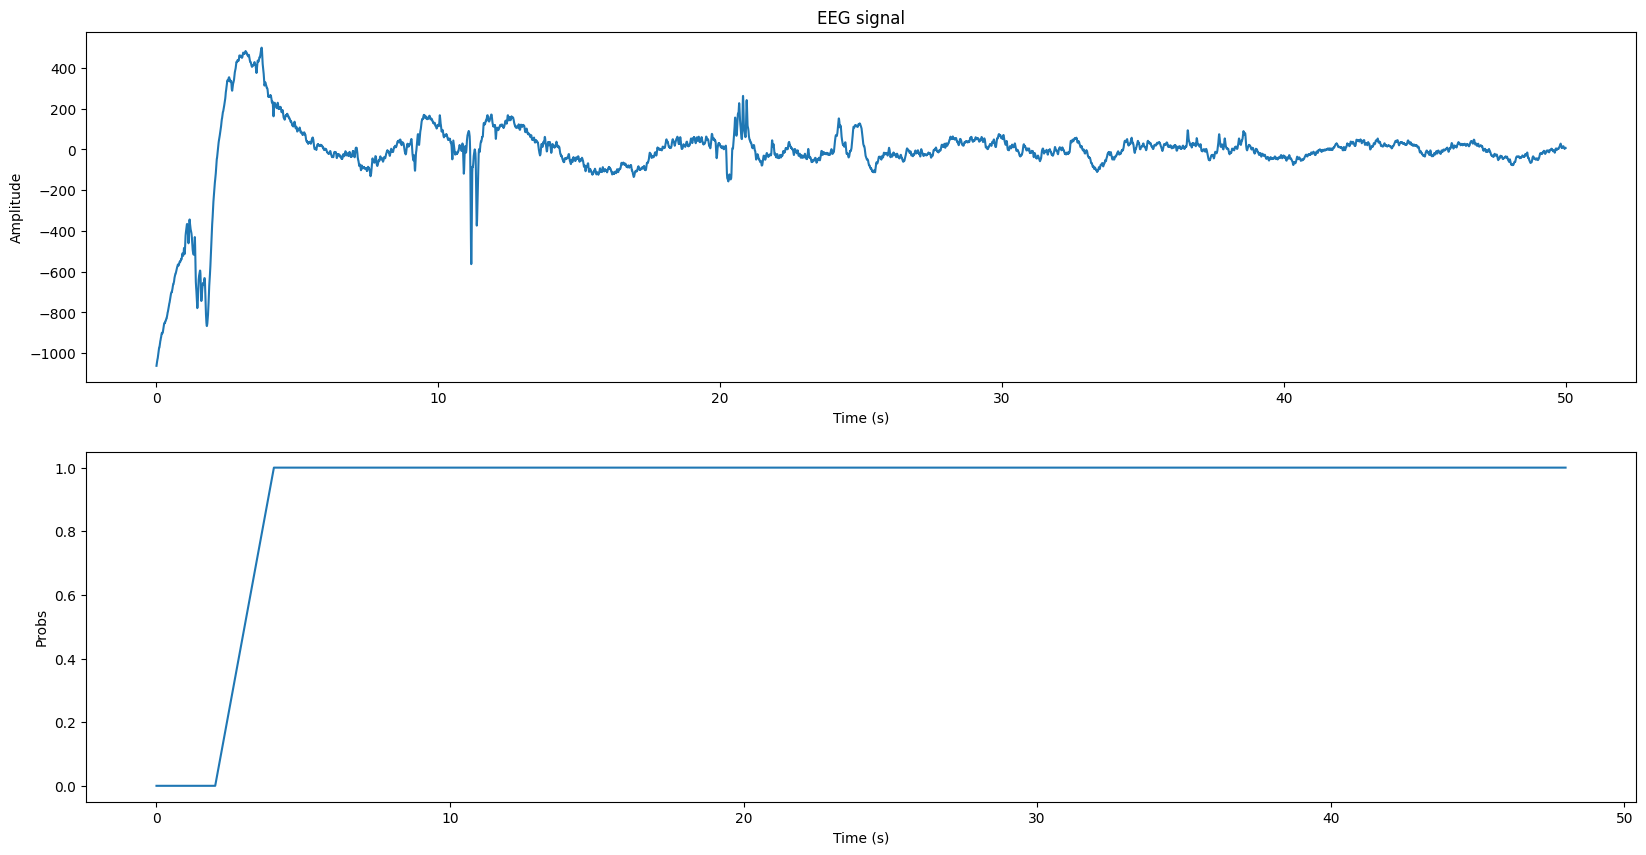

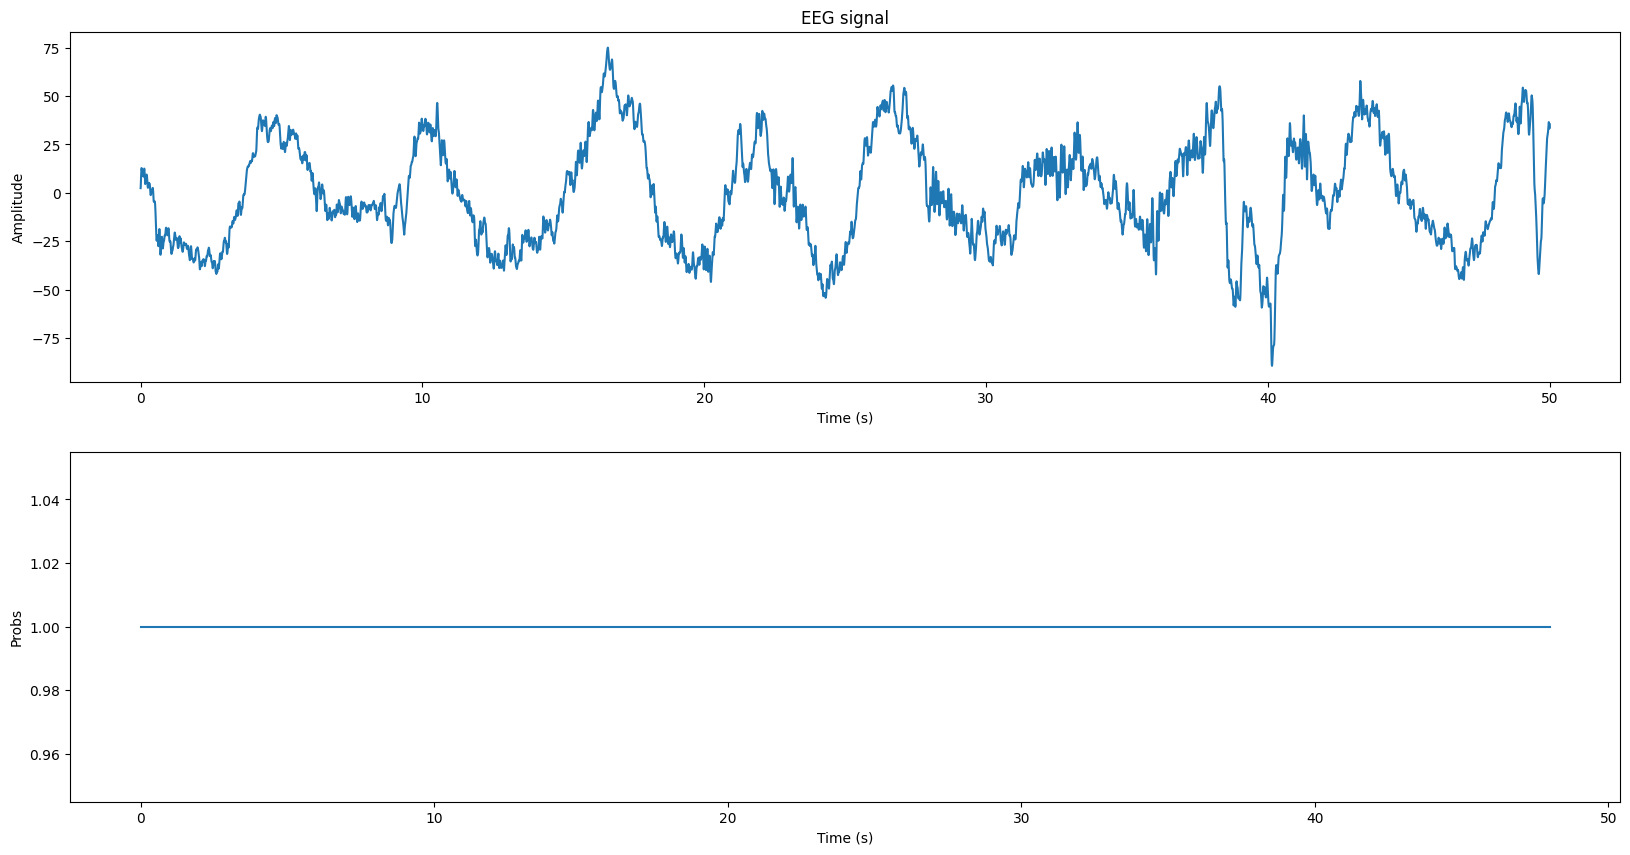

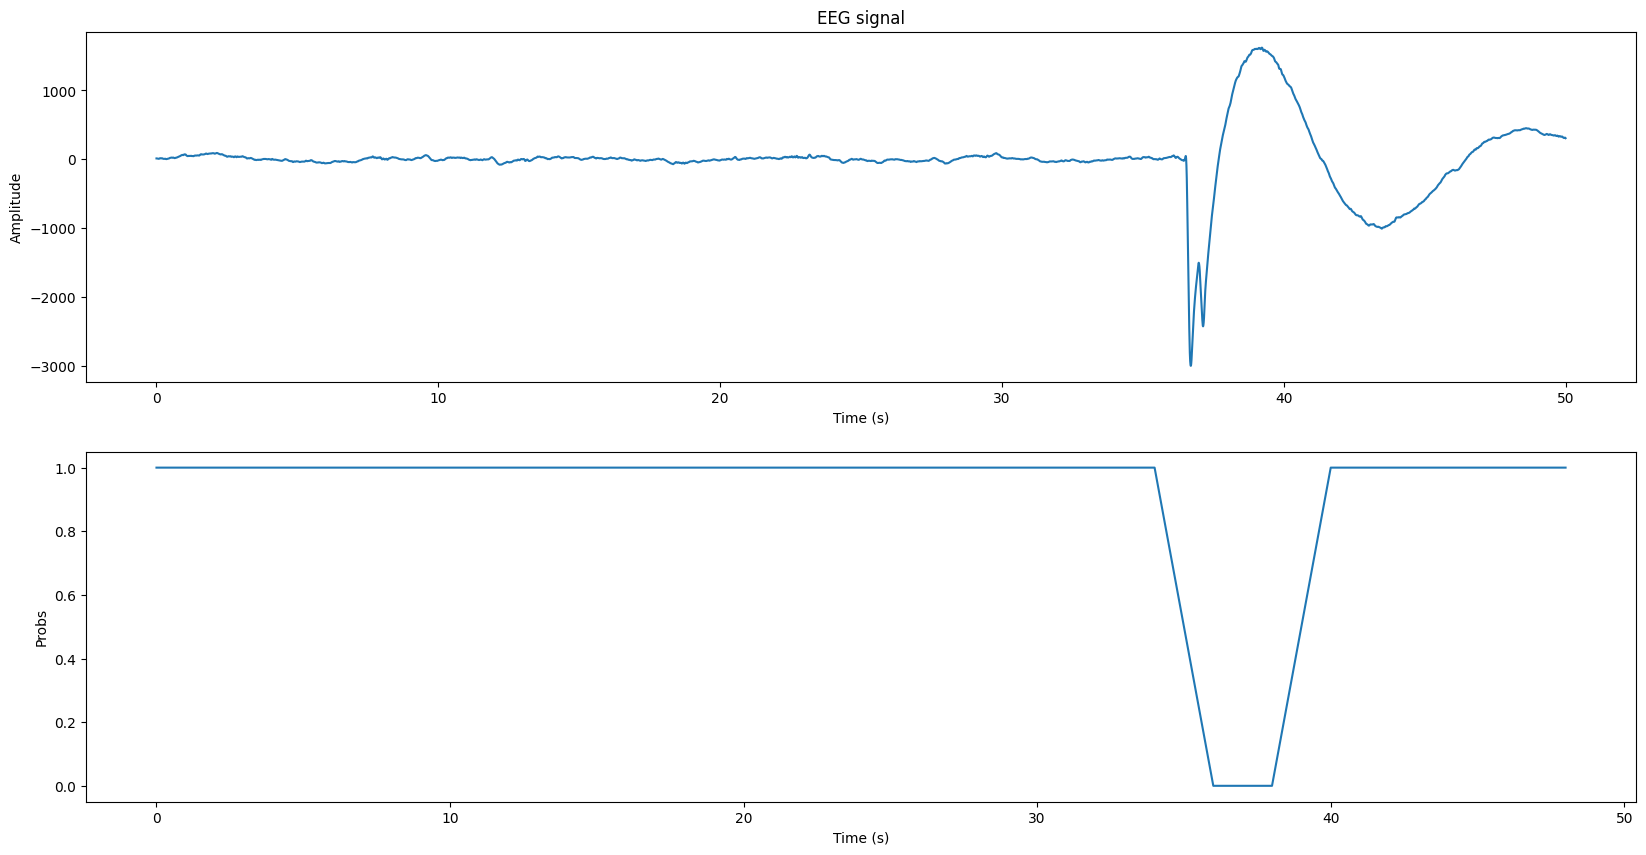

In [71]:
# Let's filter the signal to improve the visualisation

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

filtered_data = butter_bandpass_filter(data,0.1,18,250,4)
# We plot three spans and associated labels from the recording

plot_predictions_and_signal(target,filtered_data,start_time = 300, stop_time = 350, data_sampling_rate = 250,target_duration = 2 ,channel_to_plot = 2)
plot_predictions_and_signal(target,filtered_data,start_time = 1000, stop_time = 1050, data_sampling_rate = 250,target_duration = 2 ,channel_to_plot = 2)
plot_predictions_and_signal(target,filtered_data,start_time = 3000, stop_time = 3050, data_sampling_rate = 250,target_duration = 2 ,channel_to_plot = 2)

We see that some of the high amplitude is classified as bad quality, we could use that to build a first simple model

## Exploring the statistics of the good and bad quality EEG

In [72]:
# First we need to get the point that maps to a label

def reshape_array_into_windows(x, sample_rate, window_duration_in_seconds):
    """
    Reshape the data into an array of shape (C, T, window) where 'window' contains
    the points corresponding to 'window_duration' seconds of data.

    Parameters:
    x (numpy array): The input data array.
    sample_rate (int): The number of samples per second.
    window_duration_in_seconds (float): The duration of each window in seconds.

    Returns:
    reshaped_x (numpy array): The reshaped array with shape (C, T, window).
    """
    # Calculate the number of samples in one window
    window_size = int(window_duration_in_seconds * sample_rate)
    
    # Ensure the total length of x is a multiple of window_size
    total_samples = x.shape[-1]
    if total_samples % window_size != 0:
        # Truncate or pad x to make it divisible by window_size
        x = x[..., :total_samples - (total_samples % window_size)]
    # Reshape x into (C, T, window)
    reshaped_x = x.reshape(x.shape[0], -1, window_size)

    return reshaped_x


In [73]:
reshaped_array = reshape_array_into_windows(filtered_data,250,2)
# Quick unit test to ensure the reshape worked as expected
assert np.array_equal(reshaped_array[0,0],filtered_data[0,:500])
assert np.array_equal(reshaped_array[0,1],filtered_data[0,500:1000])
assert np.array_equal(reshaped_array[0,10],filtered_data[0,5000:5500])
assert np.array_equal(reshaped_array[1,1],filtered_data[1,500:1000])


In [74]:
# We can now compute the mean, max and stdev over each 2 seconds segment to try to build features
amplitude = (np.max(reshaped_array,-1) - np.min(reshaped_array,-1)).reshape(-1)
targets_flatten = target[..., :len(reshaped_array[0])].reshape(-1)

In [75]:
data = pd.DataFrame({"amplitude":amplitude,"target":targets_flatten})

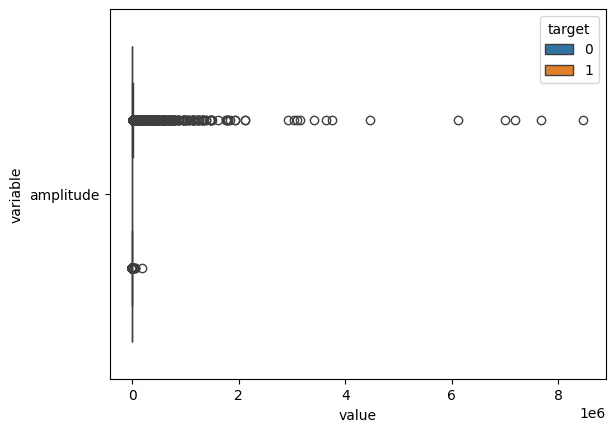

In [76]:
melted_data = pd.melt(data, value_vars = ["amplitude"],id_vars = "target")
sns.boxplot(melted_data,y = "variable", x = "value",hue = "target")
plt.show()

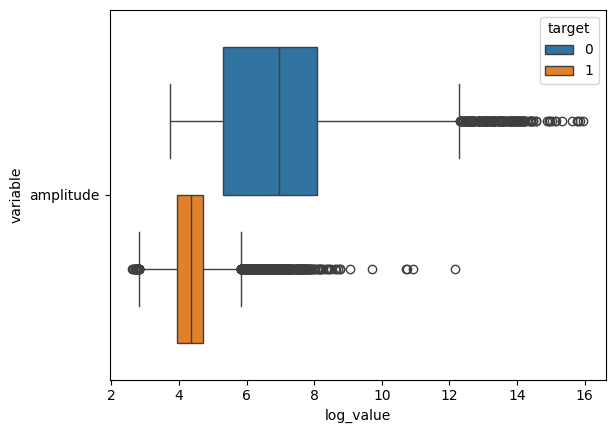

In [77]:
# We need to take the log to visualize the data better
# The goof (target = 1) and bad (target = 0) data seems to be relatively separable based on our three features
melted_data["log_value"] = np.abs(np.log(melted_data.value + 1))
sns.boxplot(melted_data,y = "variable", x = "log_value",hue = "target")
plt.show()

## Building a simple model based on our observation

In [78]:
# We first load and reshape all the data
all_data = []
all_targets = []
for (data,target) in training_data:
    filtered_data =  butter_bandpass_filter(data,0.1,18,250,4)
    reshaped_data = reshape_array_into_windows(filtered_data,250,2)
    targets_flatten = target[..., :len(reshaped_data[0])].reshape(-1)
    reshaped_data = reshaped_data.reshape((-1,reshaped_data.shape[-1]))
    all_data.append(reshaped_data)
    all_targets.append(targets_flatten)
all_data = np.concatenate(all_data)
all_targets = np.concatenate(all_targets)
assert all_data.shape[0] == all_targets.shape[0]


# Choix des features

Dans un premier temps, nous allons calculer plusieurs features et essayer d'évaluer les meilleurs. 

Pour le choix des features, nous nous sommes basés sur ce papier : 

### Covariances, amplitude, moyenne et écart-type

In [79]:
# reshape to 5 channels
all_data = all_data.reshape(5,-1,500) 
print(all_data.shape)

# calculate covariance between channels
covariances = []
for i in range(all_data.shape[1]):
    cov = np.cov(all_data[:,i,:])
    covariances.append(cov)
covariances = np.array(covariances)

print(covariances.shape)

(5, 52351, 500)
(52351, 5, 5)


In [80]:
# Take the first line of the covariance matrix as a feature for the 1st channel
# The second line of the covariance matrix as a feature for the 2nd channel and so on...
cov_data = {}
for i in range(5):
    cov_data[f"cov_{i}"] = covariances[:,i]

In [25]:
all_data = all_data.reshape(-1,500)
print(all_data.shape)

(261755, 500)


In [26]:
# We can now compute the mean, max and stdev over each 2 seconds segment to try to build features
amplitude_max = (np.max(all_data,-1) - np.min(all_data,-1)).reshape(-1)
mean = np.mean(all_data,-1).reshape(-1)
std = np.std(all_data,-1).reshape(-1)
cov_1 = cov_data["cov_1"].reshape(-1)
cov_2 = cov_data["cov_2"].reshape(-1)
cov_3 = cov_data["cov_3"].reshape(-1)
cov_4 = cov_data["cov_4"].reshape(-1)

### Delta, theta, alpha, beta and gamma frequencies

In [27]:
import numpy as np
from scipy.signal import welch

def compute_fft_features_flattened(eeg_epochs, fs):
    """
    Compute FFT-based features for pre-segmented and flattened EEG epochs.

    Parameters:
        eeg_epochs (np.ndarray): Flattened EEG data of shape (epochs, samples).
        fs (int): Sampling frequency in Hz.

    Returns:
        list[dict]: List of dictionaries containing FFT features for each epoch.
    """
    # Define frequency bands (in Hz)
    freq_bands = {
        "delta": (0.5, 4),
        "theta": (4, 8),
        "alpha": (8, 13),
        "beta": (13, 30),
        "gamma": (30, 100),
    }

    # Initialize a list to store features for all epochs
    features_list = []

    # Iterate through each epoch
    for epoch_idx, epoch in enumerate(eeg_epochs):
        epoch_features = {}

        # Compute Welch's method for power spectral density
        f, psd = welch(epoch, fs, nperseg=len(epoch))

        # Calculate power for each frequency band
        for band, (low, high) in freq_bands.items():
            idx_band = np.logical_and(f >= low, f <= high)
            band_power = np.sum(psd[idx_band])
            # Store feature with descriptive key
            epoch_features[f"epoch_{epoch_idx}_{band}_power"] = band_power

        # Append the features for this epoch
        features_list.append(epoch_features)

    return features_list

# # Example Usage
# fs = 256  # Sampling frequency in Hz
# epochs = 100  # Number of epochs
# samples = fs * 2  # 2 seconds of data per epoch

# # Example EEG data: (epochs, samples)
# eeg_epochs = np.random.randn(epochs, samples)  # Replace with actual flattened EEG epochs

# features = compute_fft_features_flattened(eeg_epochs, fs)

In [28]:
fft_features = compute_fft_features_flattened(all_data,250)

In [29]:
# look at the data
fft_features[0]

{'epoch_0_delta_power': 32260523.56010761,
 'epoch_0_theta_power': 1026.2789916674737,
 'epoch_0_alpha_power': 94.38020684726263,
 'epoch_0_beta_power': 77.67272734139593,
 'epoch_0_gamma_power': 1.2036254693475639}

### Cepstral coefficients

In [30]:
# Compute cepstral coefficients

from scipy.fftpack import dct

def compute_cepstral_coefficients(data, num_coefficients=2):
    """
    Compute the cepstral coefficients of the data.
    
    Parameters:
    data (numpy array): The input data array.
    num_coefficients (int): The number of cepstral coefficients to compute.
    
    Returns:
    cepstral_coefficients (numpy array): The cepstral coefficients of the data.
    """
    # Compute the FFT of the data
    fft_values = np.fft.rfft(data)
    
    # Compute the power spectrum
    power_spectrum = np.abs(fft_values) ** 2
    
    # Compute the log of the power spectrum
    log_power_spectrum = np.log(power_spectrum + 1e-10)
    
    # Compute the cepstral coefficients
    cepstral_coefficients = dct(log_power_spectrum, type=2, axis=0, norm="ortho")[:num_coefficients]
    
    return cepstral_coefficients

In [31]:
cepstral_coeff = []
for i in range(all_data.shape[0]):
    cepstral_coeff.append(compute_cepstral_coefficients(all_data[i],num_coefficients=1))
print(len(cepstral_coeff[0]))

1


In [32]:
all_data[0].shape

(500,)

### Comparaison des features 

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


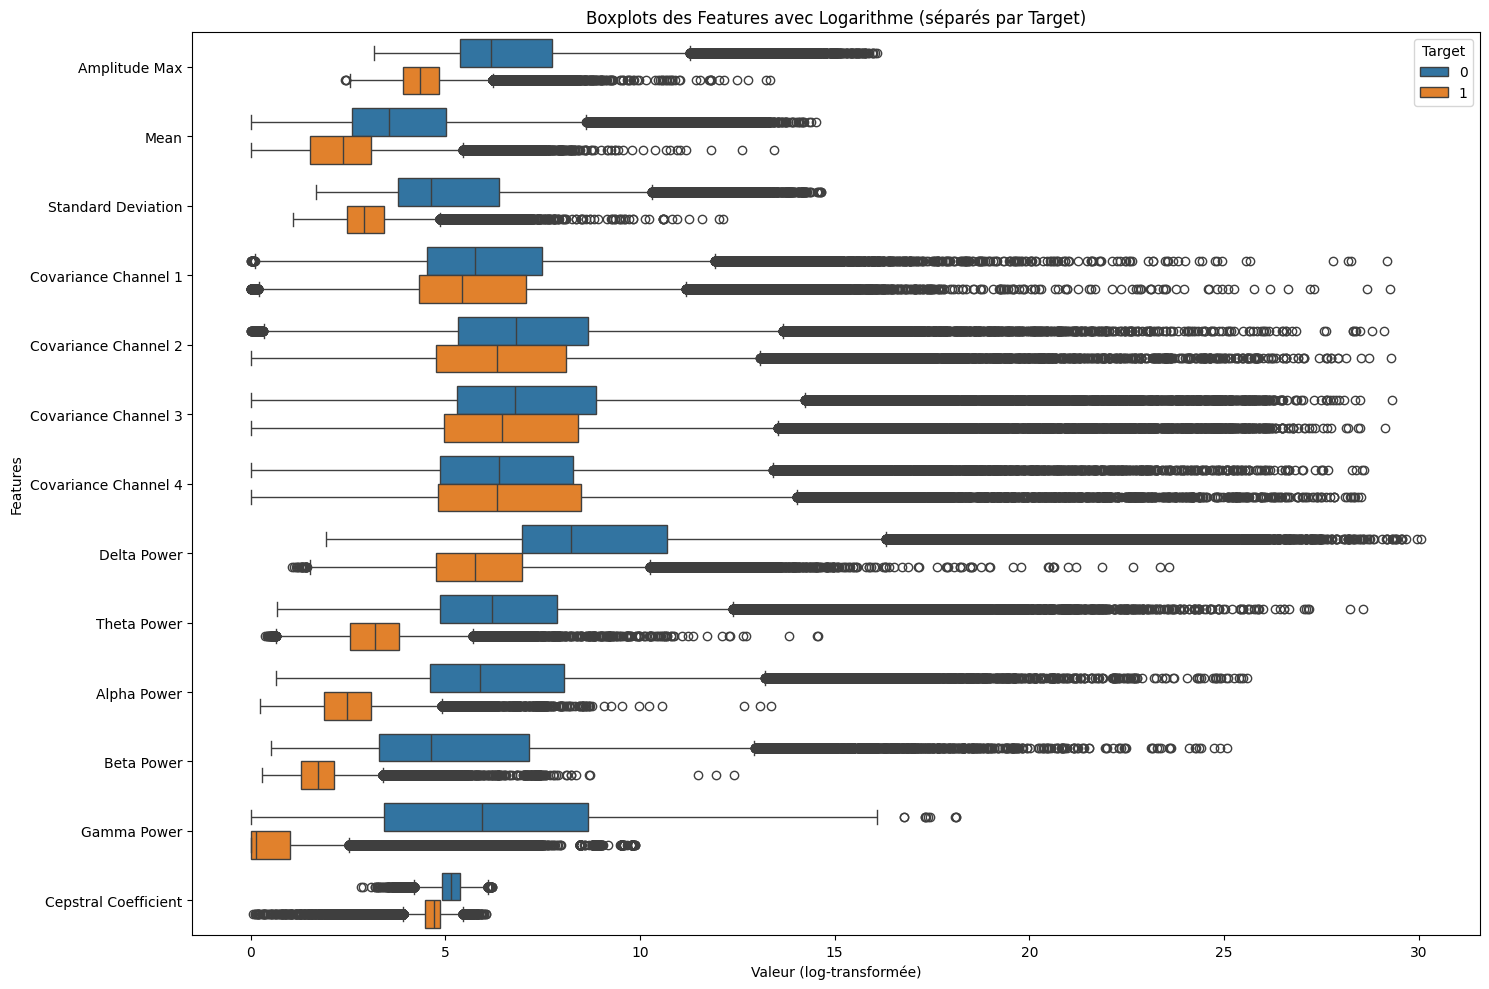

In [89]:
# Préparation des données pour les visualisations
features = {
    "Amplitude Max": amplitude_max,
    "Mean": mean,
    "Standard Deviation": std,
    "Covariance Channel 1": cov_1,
    "Covariance Channel 2": cov_2,
    "Covariance Channel 3": cov_3,
    "Covariance Channel 4": cov_4,
    "Delta Power": [x[f'epoch_{idx}_delta_power'] for idx,x in enumerate(fft_features)],
    "Theta Power": [x[f'epoch_{idx}_theta_power'] for idx,x in enumerate(fft_features)],
    "Alpha Power": [x[f'epoch_{idx}_alpha_power'] for idx,x in enumerate(fft_features)],
    "Beta Power": [x[f'epoch_{idx}_beta_power'] for idx,x in enumerate(fft_features)],
    "Gamma Power": [x[f'epoch_{idx}_gamma_power'] for idx,x in enumerate(fft_features)],
    "Cepstral Coefficient": [x[0] for x in cepstral_coeff],
}

# Combinaison des features et des cibles dans un DataFrame
data_df = pd.DataFrame(features)
data_df["target"] = all_targets  # Ajout de la cible
data_df = data_df.melt(id_vars=["target"], var_name="variable", value_name="value")

# Transformation logarithmique pour visualisation
data_df["log_value"] = np.abs(np.log(data_df["value"] + 1))

# Tracer les boxplots
plt.figure(figsize=(15, 10))
sns.boxplot(data=data_df, y="variable", x="log_value", hue="target", orient="h")
plt.title("Boxplots des Features avec Logarithme (séparés par Target)")
plt.xlabel("Valeur (log-transformée)")
plt.ylabel("Features")
plt.legend(title="Target", loc="upper right")
plt.tight_layout()
plt.show()

## Running the model on the test data and submitting to the leaderboard


In [ ]:
training_data = pd.DataFrame({"amplitude_max":amplitude_max,"mean":mean, "std":std, "delta_power": [x[f'epoch_{idx}_delta_power'] for idx,x in enumerate(fft_features)],"theta_power": [x[f'epoch_{idx}_theta_power'] for idx,x in enumerate(fft_features)],"alpha_power": [x[f'epoch_{idx}_alpha_power'] for idx,x in enumerate(fft_features)],"beta_power": [x[f'epoch_{idx}_beta_power'] for idx,x in enumerate(fft_features)],"gamma_power": [x[f'epoch_{idx}_gamma_power'] for idx,x in enumerate(fft_features)], "cepstral_coeff": cepstral_coeff,"target":all_targets})

In [ ]:
# We train a model on 70% of the data and evaluate the model on the remaining 30%
prop_train = 0.7
n_train = int(prop_train * len(training_data))
train_set = training_data[:n_train]
val_set = training_data[n_train:]

In [106]:
ROOT_TEST_PATH = Path("test/")
test_data = {i:np.load(ROOT_TEST_PATH / f"data_{i}.npy") for i in [4,5]}
# We process each record independantly

def compute_features_on_record(data):
    """
    We compute each of the feature for each window and each channel
    Each value of the output dict has shape (Channels,T)
    """
    filtered_data =  butter_bandpass_filter(data,0.1,18,250,4)
    reshaped_data = reshape_array_into_windows(filtered_data,250,2)
    amplitude_max = (np.max(reshaped_data,-1) - np.min(reshaped_data,-1))
    mean = np.mean(reshaped_data,-1)
    std = np.std(reshaped_data,-1)
    delta_power = []
    theta_power = []
    alpha_power = []
    beta_power = []
    gamma_power = []
    cepstral_coeff = [[] for i in range(5)]

    for channel in range(5):
        fft_features= compute_fft_features_flattened(reshaped_data[channel],250)
        delta_power.append([x[f'epoch_{idx}_delta_power'] for idx,x in enumerate(fft_features)])
        theta_power.append([x[f'epoch_{idx}_theta_power'] for idx,x in enumerate(fft_features)])
        alpha_power.append([x[f'epoch_{idx}_alpha_power'] for idx,x in enumerate(fft_features)])
        beta_power.append([x[f'epoch_{idx}_beta_power'] for idx,x in enumerate(fft_features)])
        gamma_power.append([x[f'epoch_{idx}_gamma_power'] for idx,x in enumerate(fft_features)])
        for tw in reshaped_data[channel]:
            cepstral_coeff[channel].append(compute_cepstral_coefficients(tw,num_coefficients=1)[0])

    return {"amplitude_max":amplitude_max, "mean":mean, "std":std, "delta_power":delta_power,"theta_power":theta_power,"alpha_power":alpha_power,"beta_power":beta_power,"gamma_power":gamma_power, "cepstral_coeff" : cepstral_coeff}

def compute_predictions_on_record(data,model,features_name_for_model):
    predictions = []
    features = compute_features_on_record(data)
    features = np.array([features[k] for k in features_name_for_model]) 
    features = features.swapaxes(0,1).swapaxes(1,2)
    for channel in range(features.shape[0]):
        predictions.append(model.predict(features[channel]))
    return np.array(predictions)

def format_array_to_target_format(array, record_number):
    assert isinstance(record_number, int)
    assert isinstance(array, np.ndarray)
    assert len(array.shape) == 2
    assert array.shape[0] == 5
    assert set(np.unique(array)) == {0, 1}
    formatted_target = []
    for i in range(array.shape[0]):
        channel_encoding = (i + 1) * 100000
        record_number_encoding = record_number * 1000000
        for j in range(array.shape[1]):
            formatted_target.append(
                {
                    "identifier": record_number_encoding + channel_encoding + j,
                    "target": array[i, j],
                }
            )
    return formatted_target
    


With the functions defined above, we can now run the model and submit the predictions

In [37]:
results = []
for record_number, data in test_data.items():
    preds = compute_predictions_on_record(data,neigh,["amplitude_max","mean","std", "delta_power", "theta_power", "alpha_power", "beta_power", "gamma_power", "cepstral_coeff"])
    formatted_preds = format_array_to_target_format(preds,record_number)
    results.extend(formatted_preds)
df = pd.DataFrame(results)
df.to_csv("submission_neigh.csv",index = False)

# Comparaison entre différents algorithmes de Machine Learning

In [107]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import cohen_kappa_score, f1_score

# submission1
neigh = KNeighborsClassifier(n_neighbors=8)

neigh.fit(np.array(train_set[["amplitude_max", "mean", "std", "delta_power", "theta_power", "alpha_power", "beta_power", "gamma_power", "cepstral_coeff"]]), train_set["target"])
prediction_neigh = neigh.predict(np.array(val_set[["amplitude_max", "mean", "std", "delta_power", "theta_power", "alpha_power", "beta_power", "gamma_power", "cepstral_coeff"]]))

print("KNeighbor Classifier model :")
print(cohen_kappa_score(prediction_neigh,val_set["target"]))
print(f1_score(val_set["target"],prediction_neigh))

# submission2
boosting_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(),  # Arbre de décision
    n_estimators=50,
    random_state=42
)

boosting_model.fit(np.array(train_set[["amplitude_max", "mean", "std", "alpha_power", "beta_power", "delta_power", "gamma_power", "cepstral_coeff"]]), train_set["target"])
prediction_boost = boosting_model.predict(np.array(val_set[["amplitude_max", "mean", "std", "alpha_power", "beta_power", "delta_power", "gamma_power", "cepstral_coeff"]]))

print("Ada Boost model :")
print(cohen_kappa_score(prediction_boost,val_set["target"]))
print(f1_score(val_set["target"],prediction_boost))

# submission3
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # Arbre de décision comme modèle de base
    n_estimators=10,
    random_state=42
)

bagging_model.fit(np.array(train_set[["amplitude_max", "mean", "std", "alpha_power", "beta_power", "delta_power", "gamma_power", "cepstral_coeff"]]), train_set["target"])
prediction_bagging = bagging_model.predict(np.array(val_set[["amplitude_max", "mean", "std", "alpha_power", "beta_power", "delta_power", "gamma_power", "cepstral_coeff"]]))

print("Bagging model :")
print(cohen_kappa_score(prediction_bagging,val_set["target"]))
print(f1_score(val_set["target"],prediction_bagging))

# submission4
XGB_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)

XGB_model.fit(np.array(train_set[["amplitude_max", "mean", "std", "alpha_power", "beta_power", "delta_power", "gamma_power", "cepstral_coeff"]]), train_set["target"])
prediction_XGB = XGB_model.predict(np.array(val_set[["amplitude_max", "mean", "std", "alpha_power", "beta_power", "delta_power", "gamma_power", "cepstral_coeff"]]))

print("XGB model :")
print(cohen_kappa_score(prediction_XGB,val_set["target"]))
print(f1_score(val_set["target"],prediction_XGB))



KNeighbor Classifier model :
0.604391557653062
0.7470607306793168


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Ada Boost model :
0.6668222053089732
0.7742912789439516
Bagging model :
0.7236559439124983
0.8113951672639187
XGB model :
0.7348989838841193
0.8182553811296326


Il semble que le modèle le plus efficace soit le XGBoost Classifier.

Nous allons désormais essayer d'optimiser ce modèle.

# Optimisation du modèle

Dans un premier temps, on va essayer d'optimiser les hyper parametres.

In [124]:
from sklearn.model_selection import GridSearchCV
# Example parameter grid
param_grid = {
    'max_depth': [5,6],
    'learning_rate': [0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Instantiate XGBoost
xgb = XGBClassifier(eval_metric='logloss')

# Grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)
grid_search.fit(np.array(train_set[["amplitude_max", "mean", "std", "delta_power", "alpha_power", "beta_power", "gamma_power", "cepstral_coeff"]]), train_set["target"])

# Best parameters
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


Ensuite, on peux changer les features. En effet, on a vu lors de la comparaison des features que le Cesptral coefficient par exemple ne permettait pas de différencier les bonnes données des mauvaises. On peut donc tester le Classifier avec et sans le Cepstral Coefficient.

In [125]:
best_xgb = XGBClassifier(**grid_search.best_params_)

best_xgb.fit(np.array(train_set[["amplitude_max", "mean", "std", "delta_power", "alpha_power", "beta_power", "gamma_power", "cepstral_coeff"]]), train_set["target"])

prediction_xgbb = best_xgb.predict(np.array(val_set[["amplitude_max", "mean", "std", "delta_power", "alpha_power", "beta_power", "gamma_power", "cepstral_coeff"]]))


from sklearn.metrics import cohen_kappa_score, f1_score
print(cohen_kappa_score(prediction_xgbb,val_set["target"]))
print(f1_score(val_set["target"],prediction_xgbb))


0.7350716862917768
0.8188127376234636


In [129]:
best_xgb = XGBClassifier(**grid_search.best_params_)

best_xgb.fit(np.array(train_set[["amplitude_max", "mean", "std", "delta_power", "alpha_power", "beta_power", "gamma_power"]]), train_set["target"])

prediction_xgb_final1 = best_xgb.predict(np.array(val_set[["amplitude_max", "mean", "std", "delta_power", "alpha_power", "beta_power", "gamma_power"]]))


from sklearn.metrics import cohen_kappa_score, f1_score
print(cohen_kappa_score(prediction_xgb_final1,val_set["target"]))
print(f1_score(val_set["target"],prediction_xgb_final1))

0.7377731045669078
0.8206881296627723


Le résultat est effectivement meilleur sans le Cepstral coefficient.

In [130]:
results = []
for record_number, data in test_data.items():
    preds = compute_predictions_on_record(data,best_xgb,["amplitude_max","mean","std", "delta_power", "alpha_power", "beta_power", "gamma_power"])
    formatted_preds = format_array_to_target_format(preds,record_number)
    results.extend(formatted_preds)
df = pd.DataFrame(results)
df.to_csv("submission_final_1.csv",index = False)

On peut tester d'autres hyper parameters.

In [139]:
# Example parameter grid
param_grid = {
    'max_depth': [5],
    'learning_rate': [0.05,0.1],
    'n_estimators': [50,100],
    'gamma': [0, 0.1,0.2],
    'subsample': [0.8,1],
    'colsample_bytree': [0.6, 0.8,1.0],
}

# Instantiate XGBoost
xgb = XGBClassifier(eval_metric='logloss')

# Grid search
grid_search_2 = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)
grid_search_2.fit(np.array(train_set[["amplitude_max", "mean", "std", "delta_power", "alpha_power", "beta_power", "gamma_power"]]), train_set["target"])

# Best parameters
print("Best parameters:", grid_search_2.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

In [140]:
best_xgb_2 = XGBClassifier(**grid_search_2.best_params_)

best_xgb_2.fit(np.array(train_set[["amplitude_max", "mean", "std", "delta_power", "alpha_power", "beta_power", "gamma_power"]]), train_set["target"])

prediction_xgb_final2 = best_xgb_2.predict(np.array(val_set[["amplitude_max", "mean", "std", "delta_power", "alpha_power", "beta_power", "gamma_power"]]))


from sklearn.metrics import cohen_kappa_score, f1_score
print(cohen_kappa_score(prediction_xgb_final2,val_set["target"]))
print(f1_score(val_set["target"],prediction_xgb_final2))

0.7263199380247802
0.8134049649497713


In [142]:
results = []
for record_number, data in test_data.items():
    preds = compute_predictions_on_record(data,best_xgb_2,["amplitude_max","mean","std", "delta_power", "alpha_power", "beta_power", "gamma_power"])
    formatted_preds = format_array_to_target_format(preds,record_number)
    results.extend(formatted_preds)
df = pd.DataFrame(results)
df.to_csv("submission_final_2.csv",index = False)